Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a ‘sense check’ or explaining your model to others and getting criticism.

Prior predictive checks are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

They allow you to check whether you are indeed incorporating scientific knowledge into your model – in short, they help you check how credible your assumptions before seeing the data are.

They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

Here, we will implement a general routine to draw samples from the observed nodes of a model. The models are basic but they will be a steppingstone for creating your own routines. If you want to see how to do prior and posterior predictive checks in a more complex, multidimensional model, you can check [this notebook](https://github.com/aloctavodia/BAP/blob/master/extras/multinomial_ppcs.ipynb). Now, let’s sample!


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr

from scipy.special import expit as logistic


print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.3


In [2]:
az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

Lets generate a very simple linear regression model. On purpose, I’ll simulate data that don’t come from a standard Normal (you’ll see why later):

In [4]:
N = 100

true_a, true_b, predictor = 0.5, 3.0, rng.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * predictor
true_sd = 2.0

outcome = rng.normal(loc=true_mu, scale=true_sd, size=N)

f"{predictor.mean():.2f}, {predictor.std():.2f}, {outcome.mean():.2f}, {outcome.std():.2f}"

'2.87, 5.06, 9.31, 15.33'

As you can see, variation in our predictor and outcome are quite high – which is often the case with real data. And sometimes, the sampler won’t like this – and you don’t want to make the sampler angry when you’re a Bayesian… So, let’s do what you’ll often have to do with real data: standardize! This way, our predictor and outcome will have a mean of 0 and std of 1, and the sampler will be much, much happier:

In [5]:
predictor_scaled = standardize(predictor)
outcome_scaled = standardize(outcome)

f"{predictor_scaled.mean():.2f}, {predictor_scaled.std():.2f}, {outcome_scaled.mean():.2f}, {outcome_scaled.std():.2f}"

'-0.00, 1.00, -0.00, 1.00'

And now, let’s write the model with conventional flat priors and sample prior predictive samples:

In [6]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


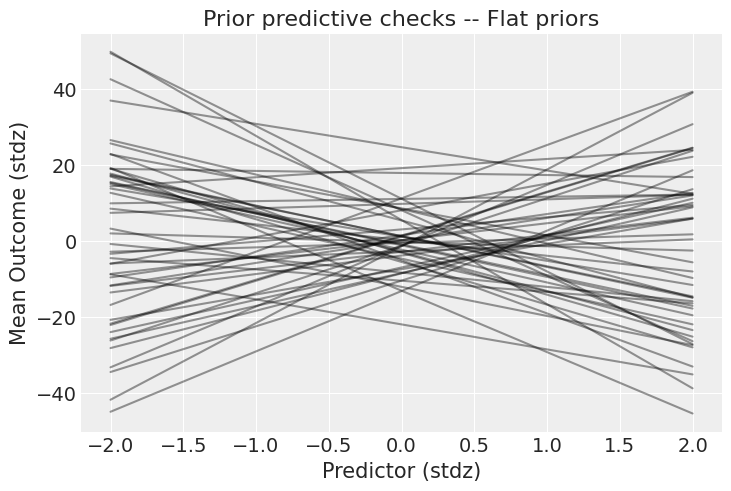

In [7]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

These priors allow for absurdly strong relationships between the outcome and predictor. Of course, the choice of prior always depends on your model and data, but look at the scale of the y axis: the outcome can go from -40 to +40 standard deviations (remember, the data are standardized). I hope you will agree this is way too permissive – we can do better! Let’s use weakly informative priors and see what they yield. In a real case study, this is the part where you incorporate scientific knowledge into your model:

In [8]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * predictor_scaled
    sigma = pm.Exponential("sigma", 1.0)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)
    idata = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [a, b, obs, sigma]


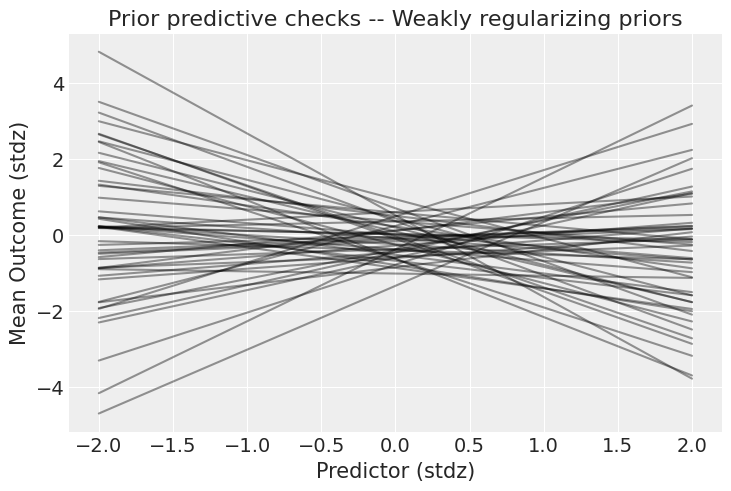

In [9]:
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

Well that’s way better! There are still very strong relationships, but at least now the outcome stays in the realm of possibilities. Now, it’s time to party – if by “party” you mean “run the model”, of course.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


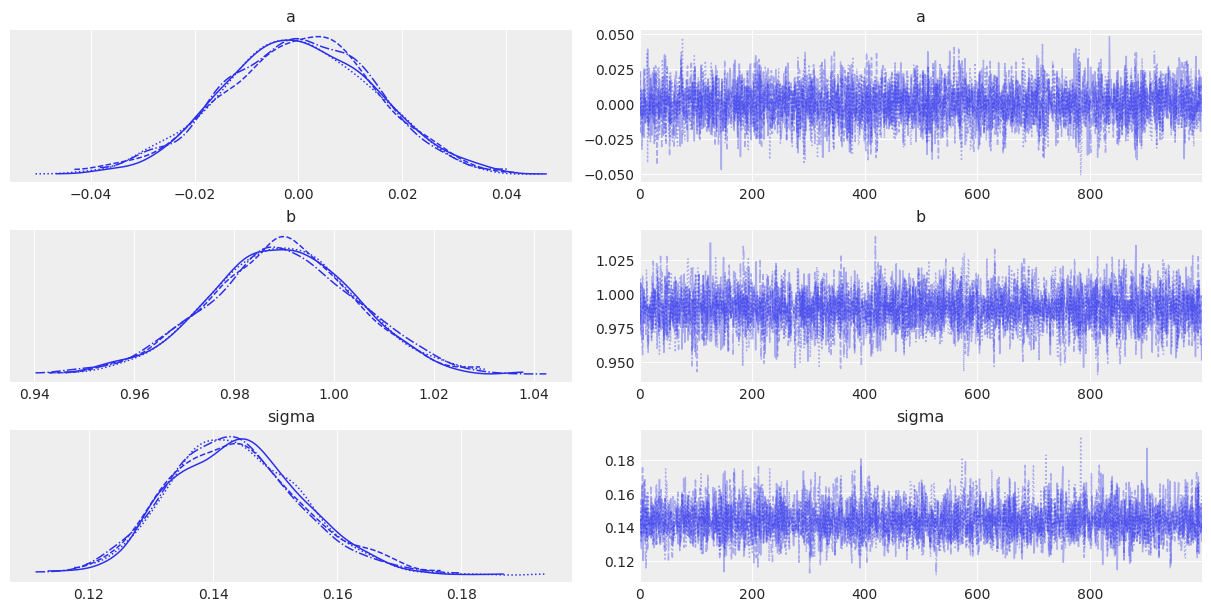

In [11]:
with model_1:
    idata.extend(pm.sample(1000, tune=2000, random_seed=rng))

az.plot_trace(idata);

Everything ran smoothly, but it’s often difficult to understand what the parameters’ values mean when analyzing a trace plot or table summary – even more so here, as the parameters live in the standardized space. A useful thing to understand your models is… you guessed it: posterior predictive checks! We’ll use PyMC’s dedicated function to sample data from the posterior. This function will randomly draw 4000 samples of parameters from the trace. Then, for each sample, it will draw 100 random numbers from a normal distribution specified by the values of mu and sigma in that sample:

In [12]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [obs]


In [13]:
idata.posterior_predictive

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, obs_dim_2: 100)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * obs_dim_2  (obs_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    obs        (chain, draw, obs_dim_2) float64 -1.88 0.7961 ... -0.006081
Attributes:
    created_at:                 2023-12-23T02:50:11.280578
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.3

One common way to visualize is to look if the model can reproduce the patterns observed in the real data. ArviZ has a really neat function to do that out of the box:

/usr/local/lib/python3.10/dist-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


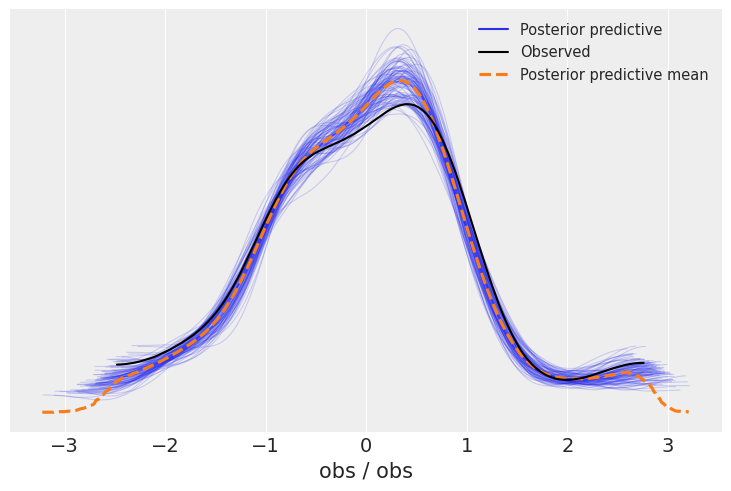

In [14]:
az.plot_ppc(idata, num_pp_samples=100);

It looks like the model is pretty good at retrodicting the data. In addition to this generic function, it’s always nice to make a plot tailored to your use-case. Here, it would be interesting to plot the predicted relationship between the predictor and the outcome. This is quite easy, now that we already sampled posterior predictive samples – we just have to push the parameters through the model:

In [15]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

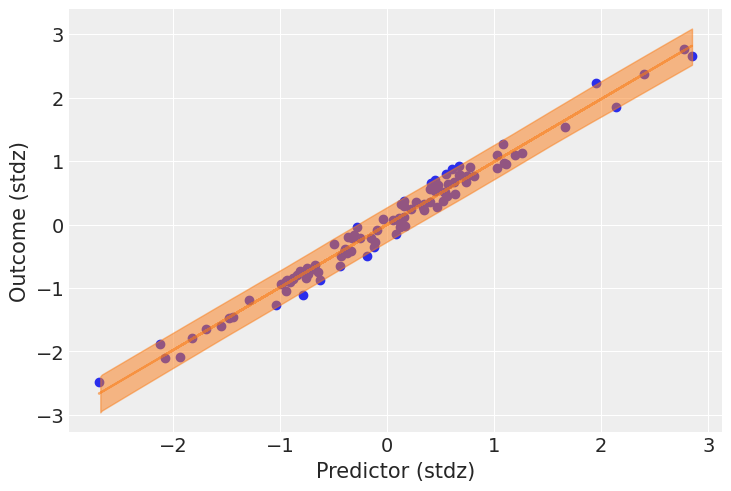

In [18]:
_, ax = plt.subplots()

ax.plot(
    predictor_scaled, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor_scaled, idata.observed_data["obs"])
az.plot_hdi(predictor_scaled, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Outcome (stdz)");

We have a lot of data, so the uncertainty around the mean of the outcome is pretty narrow; but the uncertainty surrounding the outcome in general seems quite in line with the observed data.

# Comparison between PPC and other model evaluation methods.

PPCs are an excellent tool for revising models, simplifying or expanding the current model as one examines how well it fits the data. They are inspired by prior checks and classical hypothesis testing, under the philosophy that models should be criticized under the frequentist perspective of large sample assessment.

PPCs can also be applied to tasks such as hypothesis testing, model comparison, model selection, and model averaging. It’s important to note that while they can be applied as a form of Bayesian hypothesis testing, hypothesis testing is generally not recommended: binary decision making from a single test is not as common a use case as one might believe. We recommend performing many PPCs to get a holistic understanding of the model fit.

# Prediction

The same pattern can be used for prediction. Here, we are building a logistic regression model:

In [19]:
N = 400
true_intercept = 0.2
true_slope = 1.0
predictors = rng.normal(size=N)
true_p = logistic(true_intercept + true_slope * predictors)

outcomes = rng.binomial(1, true_p)
outcomes[:10]

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [20]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    pred = pm.MutableData("pred", predictors, dims="obs_id")
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred), dims="obs_id")

    outcome = pm.Bernoulli("outcome", p=p, observed=outcomes, dims="obs_id")

    idata_2 = pm.sample(1000, tune=2000, return_inferencedata=True, random_seed=rng)
az.summary(idata_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.13,0.11,-0.07,0.35,0.0,0.0,4348.59,2896.63,1.0
betas[1],0.97,0.12,0.73,1.20,0.0,0.0,3990.71,2839.77,1.0


Now, let’s simulate out-of-sample data to see how the model predicts them. We’ll give the new predictors to the model and it’ll then tell us what it thinks the outcomes are, based on what it learned in the training round. We’ll then compare the model’s predictions to the true out-of-sample outcomes.

In [ ]:
predictors_out_of_sample = rng.normal(size=50)
outcomes_out_of_sample = rng.binomial(
    1, logistic(true_intercept + true_slope * predictors_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"pred": predictors_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    idata_2 = pm.sample_posterior_predictive(
        idata_2,
        var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,
        random_seed=rng,
    )

In [24]:
idata_2

Inference data with groups:
	> posterior
	> predictions
	> sample_stats
	> observed_data
	> constant_data
	> predictions_constant_data

## Mean predicted values plus error bars to give a sense of uncertainty in prediction

Note that since we are dealing with the full posterior, we are also getting uncertainty in our predictions for free.

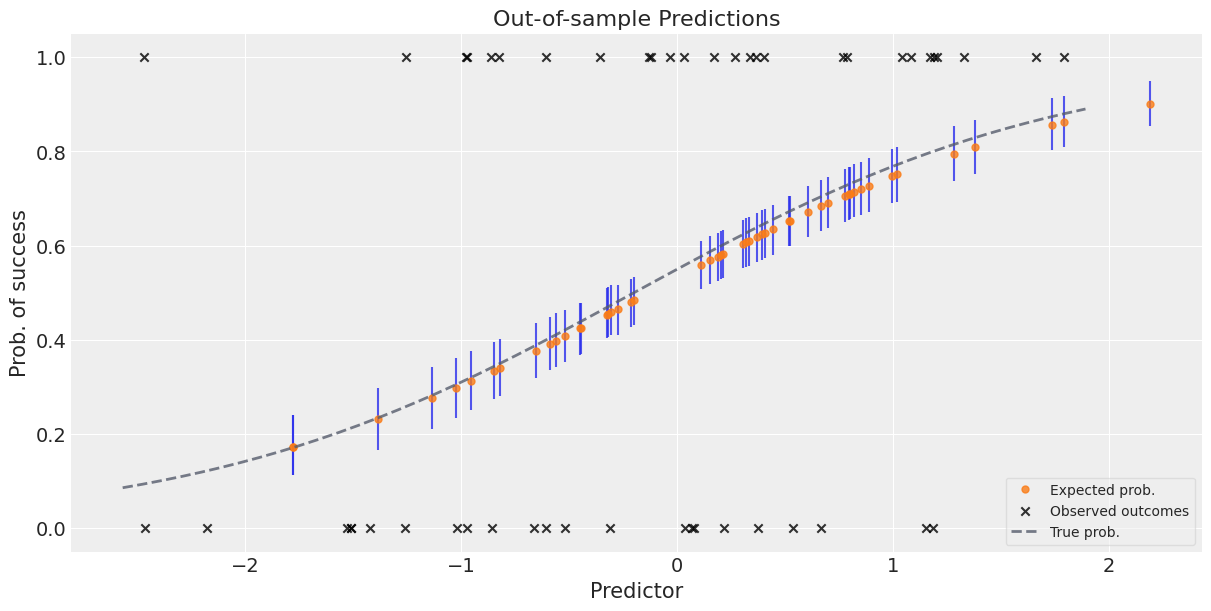

In [25]:
_, ax = plt.subplots(figsize=(12, 6))

preds_out_of_sample = idata_2.predictions_constant_data.sortby("pred")["pred"]
model_preds = idata_2.predictions.sortby(preds_out_of_sample)

# uncertainty about the estimates:
ax.vlines(
    preds_out_of_sample,
    *az.hdi(model_preds)["p"].transpose("hdi", ...),
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    preds_out_of_sample,
    model_preds["p"].mean(("chain", "draw")),
    "o",
    ms=5,
    color="C1",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=predictors_out_of_sample,
    y=outcomes_out_of_sample,
    marker="x",
    color="k",
    alpha=0.8,
    label="Observed outcomes",
)
# true probabilities:
x = np.linspace(predictors_out_of_sample.min() - 0.1, predictors_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("Predictor")
ax.set_ylabel("Prob. of success")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);